# Fine-grained sentiment analysis of Yelp restaurant reviews with pytorch

The dataset used in this project has been provided by yelp (https://www.yelp.com/dataset) and consists of close to 7 million reviews on different types of businesses in several different metropolitan areas in USA and Canada. The dataset is split into 5 different files: business information, reviews, tips, users and check-in data. The business information consists of information about the different businesses such as name, postal code, location, rating, business category and number of reviews. The review data is where we find all the reviews and ratings for all the different businesses as well as unique user ids. We are aware that not every review might be insightful and we will make a filtering effort at a later stage. The user file consists of information about each of the individual users such as the average rating they give and reactions they have received both on their own reviews and given to others. The check-in data provides timestamps for check-ins made at each individual business while the tip data consists of data similar to the reviews but in a condensed way. Both are not being used in the course of this project.


**NOTE: At several points of this notebook we pickle the results to save computation time. These intermediary results are delivered with the hand-in of this notebook, so one can simply unpickle the results to proceed. Pandas version used to create the pkl files is 1.4.1**

## Imports and settings

In [2]:
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from stopwords import get_stopwords
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction import _stop_words
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
from cleantext import clean 
import seaborn as sn
from lime.lime_text import LimeTextExplainer
from wordcloud import WordCloud
import datetime as dt
from time import time
import transformers
from transformers import BertModel, BertTokenizer, AdamW,get_linear_schedule_with_warmup
import nltk
from sklearn.model_selection import train_test_split

from collections import defaultdict

from torch import nn, optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#download these packages once, if not already done
#nltk.download('vader_lexicon')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('omw-1.4')

In [3]:
FIG_SIZE = (8, 5)
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': FIG_SIZE})
matplotlib.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.figsize'] = FIG_SIZE

## Importing data

In [35]:
# Importing the businesses data
data_file = open("../src/data/yelp_dataset/yelp_academic_dataset_business.json", encoding="utf8")
data = []
for line in data_file:
    data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

JSONDecodeError: Unterminated string starting at: line 1 column 371 (char 370)

In [5]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [6]:
# Importing the reviews data
# Due to the large size, we restrict the analysis to the first 5Mio. reviews
data_file = open("yelp_dataset/yelp_academic_dataset_review.json", encoding="utf8")
data = []
N = 5000000 #read 5Mio reviews
n = 0

for line in data_file:
    data.append(json.loads(line))
    n += 1
    if n>=N:
        break;
        
reviews_df = pd.DataFrame(data)
data_file.close()

In [7]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
# Importing the user data
# Due to the large size, we restrict the analysis to the first 5Mio. users
data_file = open("yelp_dataset/yelp_academic_dataset_user.json", encoding="utf8")
data = []
N = 5000000 #top 5 Mio. users
n = 0

for line in data_file:
    data.append(json.loads(line))
    n += 1
    if n>=N:
        break;
        
users_df = pd.DataFrame(data)
data_file.close()

In [9]:
users_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


## 1 - Exploratory Data Analysis

### Exploring the reviews data

In [10]:
reviews_df.describe()

,stars,useful,funny,cool
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,3.748844e+00,1.176868e+00,3.238060e-01,4.937522e-01
std,1.476625e+00,2.906969e+00,1.512593e+00,1.987271e+00
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,5.390000e+02,2.840000e+02,2.610000e+02


In [11]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 343.3+ MB


We can see that on average the reviewers are rating the businesses with 3.75 stars on a scale from 1 to 5, indicating that there is a tendency towards higher ratings in the data. Also, on average the reviews are given 1.2 up-votes ("useful") from other users, which points us towards rather using reviews that received such up-votes than ones which have not been considered useful. Lastly, there doesn't seem to be any missing information so that we can proceed using the reviews data as-is, which is also in line with our expectation after reading the documentation for the dataset offered by Yelp (https://www.yelp.com/dataset).

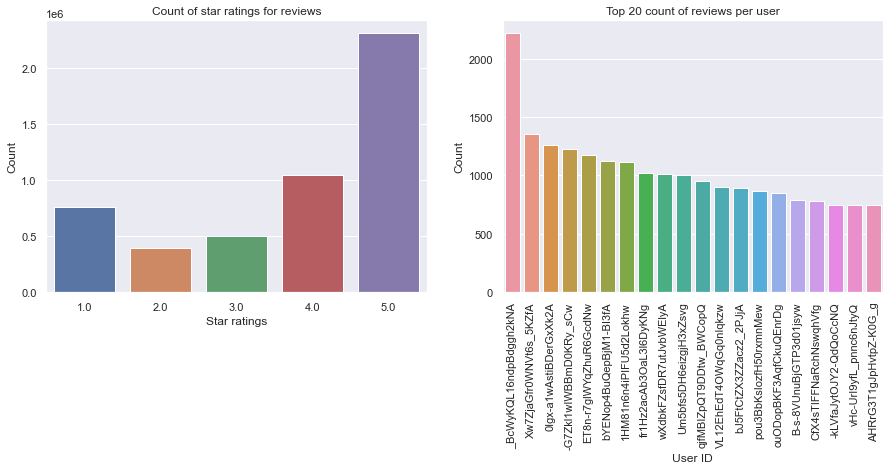

In [12]:
#check the distribution of some variables
stars = reviews_df['stars'].value_counts()
users = reviews_df['user_id'].value_counts()

fig, axes = plt.subplots(1,2,figsize=(15,5))

#distrubution of star ratings
sns.barplot(ax=axes[0], x = stars.index, y = stars.values)
axes[0].set_title("Count of star ratings for reviews")
axes[0].set_xlabel("Star ratings")
axes[0].set_ylabel("Count")

#distribution of top 20 users that gave a rating
sns.barplot(ax=axes[1], x = users.index[:20], y = users.values[:20])
axes[1].set_title("Top 20 count of reviews per user")
axes[1].set_xlabel("User ID")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(users.index[:20], rotation=90)

plt.show()

### Exploring the business data

In [18]:
business_df.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


In [19]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


The businesses data also seems to be complete in terms of the columns that we want to use, so that there is no need for further processing. We see that the average star rating for businesses of 3.6 again indicates that the ratings are skewed towards higher ones. The average count of reviews per businesses is 45, which also is in line with what we observed in the reviews dataframe. 

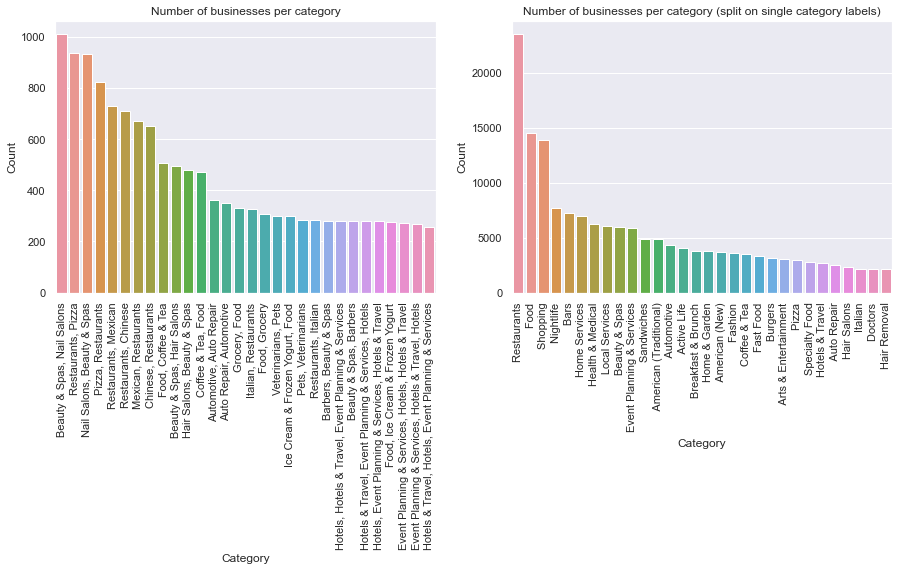

In [20]:
#check the distribution of some variables
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Category data
counts_cat = business_df.groupby('categories').count().sort_values(by='business_id', ascending = False)
sns.barplot(ax=axes[0], x=counts_cat.index[0:30], y=counts_cat['business_id'].iloc[0:30])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title("Number of businesses per category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")

#Category data detailed
business_cats = ''.join(business_df['categories'].astype('str'))
cats=pd.DataFrame(business_cats.split(','),columns=['categories'])

num_cats=cats.categories.value_counts()
num_cats=num_cats.sort_values(ascending=False)
num_cats=num_cats.iloc[0:30]

sns.barplot(ax=axes[1], x=num_cats.index, y=num_cats.values)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title("Number of businesses per category (split on single category labels)")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Count")

plt.show()

In [36]:
#merge the reviews dataset with some user information
reviews_users_df = reviews_df.merge(users_df, how='inner', on="user_id", suffixes=('_review','_user'))

#drop the columns that won't be needed
reviews_users_df = reviews_users_df.drop(['yelping_since', 'elite', 'friends', 'fans', 'compliment_hot', 'compliment_more',
                       'compliment_profile', 'compliment_cute', 'compliment_cute', 'compliment_list',
                       'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny',
                       'compliment_writer', 'compliment_photos'], axis=1)

#merge the reviews and users data with businesses data
df = reviews_users_df.merge(business_df, how='inner', on="business_id", suffixes=('_review','_business'))

#drop the columns that won't be needed
df = df.drop(['address', 'latitude', 'longitude', 'is_open', 'hours'],axis=1)

NameError: name 'reviews_df' is not defined

In [ ]:
#Save pickle for quicker execution
#df.to_pickle('../src/data/Pickles/df.pkl')

### Filtering the data
Based on the initial EDA, we decided to initially focus our analysis on the following data snippet:
* Reviews for restaurants...
* ...in the postal area "70130"...
* ...that have been made in the last 3 years before the year of the last available review...
* ...where there are more than 100 reviews for a restaurant...
* ...which have been up-voted at least once...
* ...sorted by the users with the most upvotes in their history

This reduces the size of the dataframe from almost 3.4M reviews to about 10k, with reviews for about 140 different restaurants.

In [4]:
df = pd.read_pickle('../src/data/Pickles/df.pkl')

KeyboardInterrupt: 

In [36]:
#add column with year
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['year'] = pd.DatetimeIndex(df['date']).year

In [37]:
#check the size of the original dataframe (only restaurants)
df.shape

(3376775, 24)

In [38]:
#filter for postal code 70130
postal_area = df.loc[df["postal_code"]=="70130"]
postal_area.shape

(144176, 24)

In [39]:
#Keep reviews within interval of max year -3 to -1 (not the most current year, bcs we could use it for comparison purposes).
years_businesses = postal_area.groupby('business_id').max('year')
chosen_year_1 = years_businesses-1
chosen_year_1 = chosen_year_1['year']
chosen_year_2 = years_businesses-2
chosen_year_2 = chosen_year_2['year']
chosen_year_3 = years_businesses-3
chosen_year_3 = chosen_year_3['year']

year_1 = postal_area.merge(chosen_year_1, on=['business_id', 'year'], how='inner')
year_2 = postal_area.merge(chosen_year_2, on=['business_id', 'year'], how='inner')
year_3 = postal_area.merge(chosen_year_3, on=['business_id', 'year'], how='inner')
year = pd.concat([year_1, year_2, year_3])
year.shape

(46824, 24)

In [40]:
#get the businesses with at least 100 reviews 
reviews_businesses = year.groupby('business_id').size()
hundred_reviews_businesses = reviews_businesses[reviews_businesses>100]
hundred_reviews = year[year["business_id"].isin(hundred_reviews_businesses.index)]

print("Number of remaining businesses: ", hundred_reviews_businesses.size)
hundred_reviews.shape

Number of remaining businesses:  141


(36766, 24)

In [41]:
#keep only the reviews that have been upvoted at least once
upvoted_reviews = hundred_reviews.loc[hundred_reviews["useful_review"]>=1]
upvoted_reviews.shape

(10733, 24)

In [42]:
#sort the results by the number of upvotes in the history of the users that gave the review
small_df = upvoted_reviews.sort_values(by="useful_user", ascending=False)

In [43]:
#Again, pickle the results
#small_df.to_pickle('../src/data/Pickles/df_small.pkl')

## 2 -	Main part
The chapters in this part aim for answering the research questions raised above based on the final filtered dataframe ("df_small") obtained from the EDA. Preceded is a chapter about text preprocessing and cleaning ("Normalization") of the reviews, as this is an essential step for effective text analysis.

## 2.0 - Text preprocessing and cleaning

### Data cleaning

In [5]:
#Import the dataset and format data
df = pd.read_pickle('../src/data/Pickles/clean_df_small.pkl')
df['stars_review'] = df['stars_review'].astype(int).astype('category')

In the cells below we will perform a cleaning of the text coming from the reviews, standardizing the data, removing stopwords and replacing irrelevant information among others.

The data is then cleaned further by removing punctuations, converting to lowercase, remove urls and currency symbols, fix ascii errors and transliterate unicodes to their closest ascii representations, a whirlwind emoji will be translated to "whirlwind" written in text. Numbers and digits are removed as they don't add anything in this context, it doesn't make much difference in this case if a review is stating that "the food was 15 minutes late" or "the food was minutes late".

Moreover, lemmatization is applied and is preferred over stemming as it's less prone to errors due to the fact that it takes the context into account. If stemming is applied we could for example end up with situations where "caring" is converted into "car" rather than "care". For some of our algorithms it seemed, however, that using the un-lemmatized text has provided superior results. We therefore create separate columns for the cleaned text, once with and once without lemmatization.

The stopwords list is based on the stopwords provided in the lecture, as well as the standard english stopwords. During the course of this project, we also further iterated through the stopwords list to add restaurant specific words that were spilling the data analysis. However, this has proven to be a very difficult task as with every new restaurant/review analysed, the perception of what should be a stopword is continuously changing.

In [6]:
#First we create a list of stopwords
stop_words=get_stopwords('en')
f_stop=open("../src/data/my_stopwords.txt")
stop_words+=[stopword.strip() for stopword in f_stop.readlines()]

In [7]:
def text_processing(text):
      # I had to name the function "clean.clean()" for it to works. 
      # If it does not work for you like this, re-name it to "clean()".
    text = clean(text,
          fix_unicode=True,  # fix various unicode errors such as emojis or other emotes
          to_ascii=True, #Transliterate to closes ASCII representation e.g a whirlwind emoji will be translated to "whirlwind" in text.
          lower=True, #convert everything to lowercase
          no_urls=True, #Remove URLS
          no_numbers=True, #Remove all numbers
          no_digits=True, #Remove all digits
          no_currency_symbols=True, #Remove all currency symbols
          no_punct=True, #Remove punctuations
          replace_with_punct="", 
          replace_with_url="", 
          replace_with_number="", 
          replace_with_digit="", 
          replace_with_currency_symbol="",
          lang="en") #Language is english, useful for example for "to_ascii"

    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in stop_words])
    return text

**Note: to perform part of the data cleaning, the clean-text package is used, which has some functions that help to optimize the code of this task. Note that the package installed for the correct operation must be "clean-text" and not "clean" and if an error is generated when executing the code, try changing "clean.clean" for "clean".**

In [8]:
df['text_clean'] = df['text']
df['text_clean'] = df['text_clean'].apply(lambda x: text_processing(x))

KeyboardInterrupt: 

In [ ]:
#apply lemmatization
def lemmatize(pandas_col):
    return ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(pandas_col)])
df['text_clean_lemma'] = df['text_clean']
df['text_clean_lemma'] = df['text_clean'].apply(lambda x: lemmatize(x))

In [49]:
#df.to_pickle('Yelp pickles\clean_df_small.pkl')

In [9]:
#Import the dataset
df = pd.read_pickle('../src/data/Pickles/clean_df_small.pkl')

In [10]:
df.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,text,date,name_review,...,name_business,city,state,postal_code,stars_business,review_count_business,attributes,categories,year,text_clean
9211,8eqUW6mnZ0FYcjpL_6VF7w,Hi10sGSZNxQH3NLyWSZ1oA,yE6aDcbbK8pmvNroXnQYQA,4,20,13,19,Now that corona is on us\nAnd we hope the extr...,2020-07-19 23:18:10,Fox,...,Majoria's Commerce Restaurant,New Orleans,LA,70130,4.5,866,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Diners, Sandwiches, Restaurants, Breakfast & B...",2020,now corona us hope extreme right wont bomb us ...
6342,VY6AdwdPnfwhZ8BwMokH1w,hWDybu_KvYLSdEFzGrniTw,ku8cAVBLaF_4rI-yK6gNnQ,5,18,10,16,Five stars for the lovely Brittney who made ou...,2020-10-19 15:02:09,Bruce,...,Brennan's,New Orleans,LA,70130,4.0,1598,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Cajun/Creole, Restaurants",2020,five stars lovely brittney made bananas foster...
6451,zpDo1qrEYC6G8YlK1vUaDg,hWDybu_KvYLSdEFzGrniTw,iSRTaT9WngzB8JJ2YKJUig,5,22,13,19,I usually write my reviews in the order I visi...,2020-10-19 13:33:05,Bruce,...,Mother's Restaurant,New Orleans,LA,70130,3.5,5185,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...",2020,usually write reviews order visit business som...
5059,C4Sv_LbycqWNwWH4iWUdwg,Hm0diOkWwpo9zotlJlqMUQ,H41S-qS3NOUJSbIqWTuyIA,4,61,27,53,This cruise is pure New Orleans!\n\nWe used ou...,2020-03-08 19:17:44,May,...,Paddlewheeler Creole Queen,New Orleans,LA,70130,4.0,713,"{'WiFi': ''no'', 'GoodForKids': 'True', 'Resta...","Hotels & Travel, Cajun/Creole, Boat Charters, ...",2020,cruise pure new orleans used city pass ride ab...
1305,dM-QT9s9mfqlXJCOI9LJlw,Hm0diOkWwpo9zotlJlqMUQ,I6L0Zxi5Ww0zEWSAVgngeQ,4,56,25,54,It's beignet a while... Nice outdoor-style caf...,2020-03-12 01:42:05,May,...,Cafe Beignet on Bourbon Street,New Orleans,LA,70130,3.5,1066,"{'GoodForKids': 'True', 'OutdoorSeating': 'Tru...","Sandwiches, Breakfast & Brunch, Cajun/Creole, ...",2020,beignet nice outdoorstyle cafe amazing beignet...


Text(0, 0.5, 'Number of reviews')

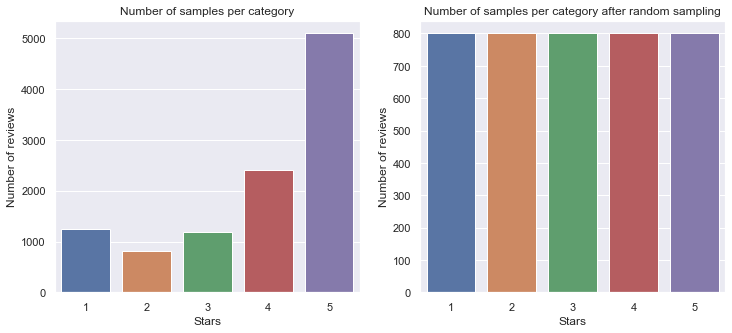

In [11]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

sns.barplot(ax=axes[0], x=df.stars_review.value_counts().index, y=df.stars_review.value_counts())
axes[0].tick_params(axis='x')
axes[0].set_title("Number of samples per category")
axes[0].set_xlabel('Stars')
axes[0].set_ylabel('Number of reviews')

#Sample the same amount of reviews from each category
df = df.groupby('stars_review').apply(lambda x: x.sample(800, random_state=42)).reset_index(drop=True)

#Used to shuffle the samples
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

sns.barplot(ax=axes[1], x=df.stars_review.value_counts().index, y=df.stars_review.value_counts())
axes[1].tick_params(axis='x')
axes[1].set_title("Number of samples per category after random sampling")
axes[1].set_xlabel('Stars')
axes[1].set_ylabel('Number of reviews')

In [12]:
# Map stars from 0-4 to reduce errors
df['stars_review'] = df['stars_review'].apply(lambda x: x-1)

### Data processing

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

sample_txt = 'Super tasty pizzas and unbeatable quality-price for Denmark, very friendly staff, I would repeat without hesitation!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Review: "+sample_txt+'\n')
print(" Tokens: "+str(tokens))
print(" Token IDS: "+str(token_ids))

Review: Super tasty pizzas and unbeatable quality-price for Denmark, very friendly staff, I would repeat without hesitation!

 Tokens: ['Super', 'ta', '##sty', 'pizza', '##s', 'and', 'un', '##beat', '##able', 'quality', '-', 'price', 'for', 'Denmark', ',', 'very', 'friendly', 'staff', ',', 'I', 'would', 'repeat', 'without', 'hesitation', '!']
 Token IDS: [3198, 27629, 13913, 13473, 1116, 1105, 8362, 14262, 1895, 3068, 118, 3945, 1111, 5140, 117, 1304, 4931, 2546, 117, 146, 1156, 9488, 1443, 13941, 106]


In [37]:
BATCH_SIZE = 16
MAX_LEN = 140

train, test = train_test_split(df, test_size=0.2)
val, test = train_test_split(test, test_size=0.5)

print("Train: {}, Test: {} Val: {}".format(train.shape, test.shape, val.shape))

Train: (3200, 25), Test: (400, 25) Val: (400, 25)


In [38]:
class GenDataset(Dataset):

  def __init__(self, text, stars_review):
    self.text = text
    self.stars_review = stars_review
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    self.max_len = MAX_LEN
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    star = self.stars_review[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stars_review': torch.tensor(star, dtype=torch.long)
    }


In [39]:
def create_data_loader(df):
  ds = GenDataset(
    text=df.text.to_numpy(),
    stars_review=df.stars_review.to_numpy()
  )

  return DataLoader(
    ds,
    batch_size=BATCH_SIZE
  )

In [40]:
train_data_loader = create_data_loader(train)
test_data_loader = create_data_loader(test)
val_data_loader = create_data_loader(val)

In [41]:
data = next(iter(train_data_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### 2.1.1 - Fine-Grained Sentiment Classifier

In [42]:
bert_model = BertModel.from_pretrained('bert-base-cased',return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
class FineGrainedSentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FineGrainedSentClassifier, self).__init__()
    self.bert = bert_model
    self.drop = nn.Dropout(p=0.25)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

classes = sorted(train.stars_review.unique())


model = FineGrainedSentClassifier(len(classes))

In [44]:
def train_epoch(model, data_loader, loss_fn, optimizer, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    stars_review = d["stars_review"]

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stars_review)

    correct_predictions += torch.sum(preds == stars_review)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      stars_review = d["stars_review"]

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stars_review)

      correct_predictions += torch.sum(preds == stars_review)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [47]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

loss_fn = nn.CrossEntropyLoss()

In [50]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn, optimizer,len(train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn, len(val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


KeyboardInterrupt: 

### Evaluation matrix

In [51]:
cf_matrix = confusion_matrix(df['vader_score'],df['stars_review'])
cf_matrix = pd.DataFrame(cf_matrix,columns = [0,1,2,3,4],index = [0,1,2,3,4])

# Get model accuracy and f1 score
print_accuracy(df, 'vader_score')

sn.heatmap(cf_matrix, annot=True,cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Real star rating")
plt.ylabel("Predicted star rating")
plt.show()

NameError: name 'confusion_matrix' is not defined